In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Application de la méthode de Galerkine aux données
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
#DataFolder="E:/Clément/Julie/Stage_L3"

# Importations des librairies

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D

# Chargement des données
## Définition des fonctions

In [3]:
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def nb_plan(prof):
    "Détermine le nombre de plan pour une profondeur donnée"
    if prof==5:
        return(16)
    if prof==10:
        return(32)
    if prof==15:
        return(49)
    else:
        return("prof n'a pas une valeur acceptable")
    
def donnees(n,piv):
    "Charge les données pour la profondeur donnée"
    u=np.zeros((n,60,60))
    v=np.zeros((n,60,60))
    x=np.zeros((n,60,60))
    y=np.zeros((n,60,60))
    z=np.zeros((n))

    for plan in range(n): 
            u[plan]=np.array(piv[plan]['u'])
            v[plan]=np.array(piv[plan]['v'])
            x[plan]=np.array(piv[plan]['x'])
            y[plan]=np.array(piv[plan]['y'])
            z[plan]=np.array(piv[plan]['prof'])
    return(u,v,x,y,z)

## Choix de la profondeur de travail

In [4]:
prof=10 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)

## Chargement des données

In [5]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

piv=PIV(prof,manips)#données pour la profondeur

P=nb_plan(prof)#nombre de plan dans la profondeur choisie

u,v,x,y,z=donnees(P,piv)
print(np.shape(u),np.shape(v),np.shape(x),np.shape(y),np.shape(z))

(32, 60, 60) (32, 60, 60) (32, 60, 60) (32, 60, 60) (32,)


# Application du programme de divergence bidimensionnelle
## Fonction de plot

In [6]:
def plot_divergence(div,dx,dy,title):
    "Tracé des divergences"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title)
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
   
    fig.tight_layout(pad = 3)
    fig.suptitle(title,fontsize=20)
    plt.show()

## Constitution du tableau de divergence bidimensionnelle

In [7]:
div_2D=np.zeros((P,59,59))
dx=np.zeros((P,59,59))
dy=np.zeros((P,59,59))

for plan in range(P):
    div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],1)
print(np.shape(div_2D))
print(np.shape(dy))

(32, 59, 59)
(32, 59, 59)


## Plot

<IPython.core.display.Javascript object>


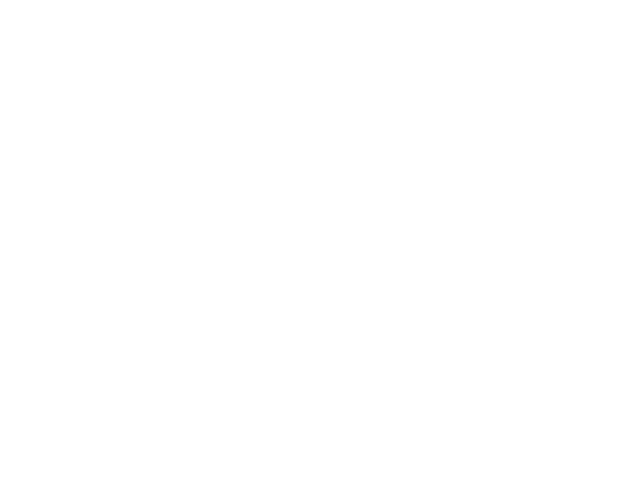

In [8]:
#%matplotlib notebook
#plan=2
#plot_divergence(div_2D[plan],dx[plan],dy[plan],"Tracé de la divergence")

# Application de la méthode de Galerkine
## Choix du nombre de mode

In [9]:
m=5

## Construction des différents tableaux
### Tableau des z

In [10]:
#z=np.reshape(z,(P,1))
print(z)
print(np.shape(z))

[ 0.7  1.   1.3  1.6  1.9  2.2  2.5  2.8  3.1  3.4  3.7  4.   4.3  4.6
  4.9  5.2  5.5  5.8  6.1  6.4  6.7  7.   7.3  7.6  7.9  8.2  8.5  8.8
  9.1  9.4  9.7 10. ]
(32,)


### Matrice M

In [11]:
h=prof
M=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)]))
M=np.reshape(M,(P,5))
print(np.shape(M))

pinv=nppinv(M)
print(np.shape(pinv))

(32, 5)
(5, 32)


# Résolution
## Coefficients
### Double boucle

In [12]:
shape=np.shape(div_2D)
print(shape)
a2=np.zeros((m,59,59))
for i in range(59):
    for j in range(59):
        a2[:,i,j]=np.matmul(pinv,div_2D[:,i,j])
print(np.shape(a2))


(32, 59, 59)
(5, 59, 59)


### Méthode à valider

In [13]:
div_2D_reshape=np.reshape(div_2D,(P,59*59)) #Est-ce que ça marche vraiment ?? Sinon le produit matriciel ne fonctionne pas..
a=np.matmul(pinv,div_2D_reshape)
#a=np.reshape(a,(5,59,59))
print(np.shape(a))

(5, 3481)


## Détermination de v_z
### Tableau des sinus

In [14]:
sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
print(np.shape(sin))

(32, 5)


### Double boucle

In [15]:
vz2=np.zeros((P,59,59))
for i in range(59):
    for j in range(59):
        vz2[:,i,j]=np.matmul(sin,a2[:,i,j])
print(np.shape(vz2))

(32, 59, 59)


### Méthode à valider

In [16]:
vz=np.matmul(sin,a)
vz=np.reshape(vz,(P,59,59))
print(np.shape(vz))

(32, 59, 59)


### Validation de la méthode

In [17]:
print("Les deux méthodes donnent le même résultat : {}".format(np.allclose(vz,vz2)))

Les deux méthodes donnent le même résultat : True


# Fonction Galerkine

In [18]:
def methode_Galerkine(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine"
    #divergence bidimensionelle
    div_2D=np.zeros((P,59,59))
    dx=np.zeros((P,59,59))
    dy=np.zeros((P,59,59))
    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],1)
    #Matrice pinv
    pinv=nppinv(np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)])))
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de vz
    sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
    vz=np.matmul(sin,a)
    vz=np.reshape(vz,(P,59,59))
    return(vz)

# Tracé des champs de vitesse pour des plans à x ou y fixé.
## Remise à la bonne forme des tableaux

In [19]:
u=u[:,:-1,:-1]
v=v[:,:-1,:-1]
x=x[:,:-1,:-1]
y=y[:,:-1,:-1]
xmax=59
ymax=59

#tableau des z:
z=np.reshape(z,(P,1))
z_2D=np.hstack((z,z))
for i in range(xmax-2):
    z_2D=np.hstack((z_2D,z))
print(np.shape(z))
print(np.shape(z_2D))

(32, 1)
(32, 59)


## Tracé des champs de vitesse 2D
### Fonction de plot

In [95]:
def plot_champ_vitesse(u,v,x,y,title,xlabel,ylabel):
    "Fonction de tracé du champ de vitesse 2D"
    velocity=np.sqrt(u**2+v**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = velocity
    colors[velocity>velmax]=velmax
    # norm = Normalize()
    # norm.autoscale(colors)
    
    #nombre de flèches
    p=1
    x=x[::p,:]
    y=y[::p,:]
    u=u[::p,:]
    v=v[::p,:]
    velocity=velocity[::p,:]
    
    #plot   
    fig,ax=plt.subplots(num=title,figsize=(8,4.5))
    im=ax.quiver(x,y,u/velocity,v/velocity,colors)
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=3)
    plt.show()

In [21]:
print(np.shape(z_2D))

(32, 59)


In [42]:
print(np.shape(u[:,y_plan,:]))
print(np.shape(v[:,:,x_plan]))
print(np.shape(vz[:,:,x_plan]))
print(np.shape(dx[:,y_plan,:]))
print(np.shape(dy[:,:,x_plan]))
print(np.shape(z_2D))

(32, 59)
(32, 59)
(32, 59)
(32, 59)
(32, 59)
(32, 59)


### Champ de vitesse à x fixé

<IPython.core.display.Javascript object>


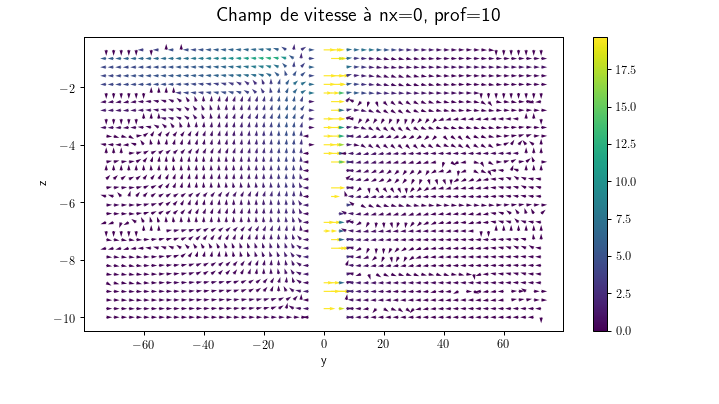

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [97]:
%matplotlib notebook
x_plan=30 #Choix de x (x va de 0 à xmax)
plot_champ_vitesse(np.transpose(v[:,:,x_plan]), np.transpose(vz[:,:,x_plan]), np.transpose(dy[:,:,x_plan]), -np.transpose(z_2D), "Champ de vitesse à nx={}, prof={}".format(x_plan-30,prof), "y", "z")
   

### Champ de vitesse à y fixé 

<IPython.core.display.Javascript object>


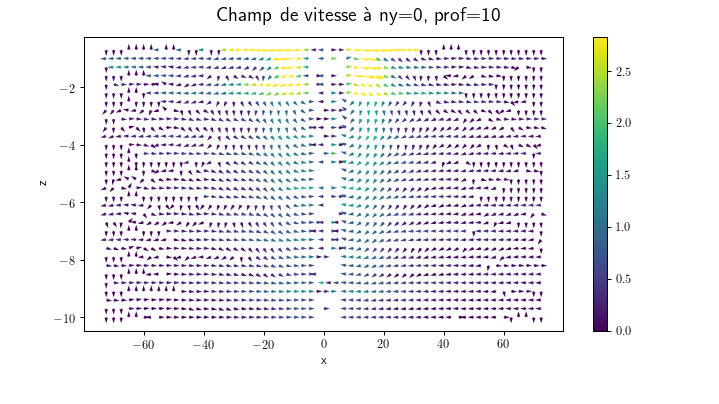

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [98]:
%matplotlib notebook
y_plan=30 #Choix de y
plot_champ_vitesse(np.transpose(u[:,y_plan,:]), np.transpose(vz[:,y_plan,:]), np.transpose(dx[:,y_plan,:]), -np.transpose(z_2D), "Champ de vitesse à ny={}, prof={}".format(y_plan-30,prof), "x", "z")


# Données sous le nageur
## fonction de plot

In [90]:
def conv(u,plan,variable_fixe):
    "Met les array sous la bonne forme"
    if variable_fixe=='x':
        return(np.transpose(u[:,:,plan]))
    elif variable_fixe=='y':
        return(np.transpose(u[:,plan,:]))


def plot_champ_vitesse_sous_nageur(u,v,vz,x,y,z,plan,title):
    "Fonction de tracé du champ de vitesse 2D"
    velocity=np.sqrt(u**2+v**2+vz**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = velocity
    colors[velocity>velmax]=velmax
    # norm = Normalize()
    # norm.autoscale(colors)
    
    #plot   
    fig,(l0,l1,l2)=plt.subplots(nrows=3,ncols=2,num=title,figsize=(15,14))
    #plans à x fixé
    im0=l0[0].quiver(conv(dy,plan-1,'x'),-np.transpose(z_2D),conv(v,plan-1,'x')/conv(velocity,plan-1,'x'),conv(vz,plan-1,'x')/conv(velocity,plan-1,'x'),conv(colors,plan-1,'x'))
    fig.colorbar(im0, ax=l0[0])
    l0[0].set_title('plan nx={}'.format(plan-31))
    l0[0].set_xlabel('y')
    l0[0].set_ylabel('z')

    im2=l1[0].quiver(conv(dy,plan,'x'),-np.transpose(z_2D),conv(v,plan,'x')/conv(velocity,plan,'x'),conv(vz,plan,'x')/conv(velocity,plan,'x'),conv(colors,plan,'x'))
    fig.colorbar(im2, ax=l1[0])
    l1[0].set_title('plan nx={}'.format(plan-30))
    l1[0].set_xlabel('y')
    l1[0].set_ylabel('z')
    
    im4=l2[0].quiver(conv(dy,plan+1,'x'),-np.transpose(z_2D),conv(v,plan+1,'x')/conv(velocity,plan+1,'x'),conv(vz,plan+1,'x')/conv(velocity,plan+1,'x'),conv(colors,plan+1,'x'))
    fig.colorbar(im4, ax=l2[0])
    l2[0].set_title('plan nx={}'.format(plan-29))
    l2[0].set_xlabel('y')
    l2[0].set_ylabel('z')
    
    #plans à y fixé
    im1=l0[1].quiver(conv(dx,plan-1,'y'),-np.transpose(z_2D),conv(u,plan-1,'y')/conv(velocity,plan-1,'y'),conv(vz,plan-1,'y')/conv(velocity,plan-1,'y'),conv(colors,plan-1,'y'))
    fig.colorbar(im1, ax=l0[1])
    l0[1].set_title('plan ny={}'.format(plan-31))
    l0[1].set_xlabel('x')
    l0[1].set_ylabel('z')
    
    im3=l1[1].quiver(conv(dx,plan,'y'),-np.transpose(z_2D),conv(u,plan,'y')/conv(velocity,plan,'y'),conv(vz,plan,'y')/conv(velocity,plan,'y'),conv(colors,plan,'y'))
    fig.colorbar(im3, ax=l1[1])
    l1[1].set_title('plan ny={}'.format(plan-30))
    l1[1].set_xlabel('x')
    l1[1].set_ylabel('z')
    
    im5=l2[1].quiver(conv(dx,plan+1,'y'),-np.transpose(z_2D),conv(u,plan+1,'y')/conv(velocity,plan+1,'y'),conv(vz,plan+1,'y')/conv(velocity,plan+1,'y'),conv(colors,plan+1,'y'))
    fig.colorbar(im5, ax=l2[1])
    l2[1].set_title('plan ny={}'.format(plan-29))
    l2[1].set_xlabel('x')
    l2[1].set_ylabel('z')

    
    fig.suptitle(title,fontsize=20)
    plt.tight_layout(pad=4)
    plt.show()
    
def plot_champ_vitesse_sous_nageur2(u,v,vz,x,y,z,plan,title):
    "Fonction de tracé du champ de vitesse 2D"
    velocity=np.sqrt(u**2+v**2+vz**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = velocity
    colors[velocity>velmax]=velmax
    # norm = Normalize()
    # norm.autoscale(colors)
    
    #plot   
    fig,l0=plt.subplots(ncols=2,num=title,figsize=(12,5))
    #plan à x fixé
    im2=l0[0].quiver(conv(dy,plan,'x'),-np.transpose(z_2D),conv(v,plan,'x')/conv(velocity,plan,'x'),conv(vz,plan,'x')/conv(velocity,plan,'x'),conv(colors,plan,'x'))
    fig.colorbar(im2, ax=l0[0])
    l0[0].set_title('plan nx={}'.format(plan-30))
    l0[0].set_xlabel('y')
    l0[0].set_ylabel('z')
    
    #plan à y fixé
    im3=l0[1].quiver(conv(dx,plan,'y'),-np.transpose(z_2D),conv(u,plan,'y')/conv(velocity,plan,'y'),conv(vz,plan,'y')/conv(velocity,plan,'y'),conv(colors,plan,'y'))
    fig.colorbar(im3, ax=l0[1])
    l0[1].set_title('plan ny={}'.format(plan-30))
    l0[1].set_xlabel('x')
    l0[1].set_ylabel('z')
    
    fig.suptitle(title,fontsize=20)
    plt.tight_layout(pad=4)
    plt.show()
    

<IPython.core.display.Javascript object>


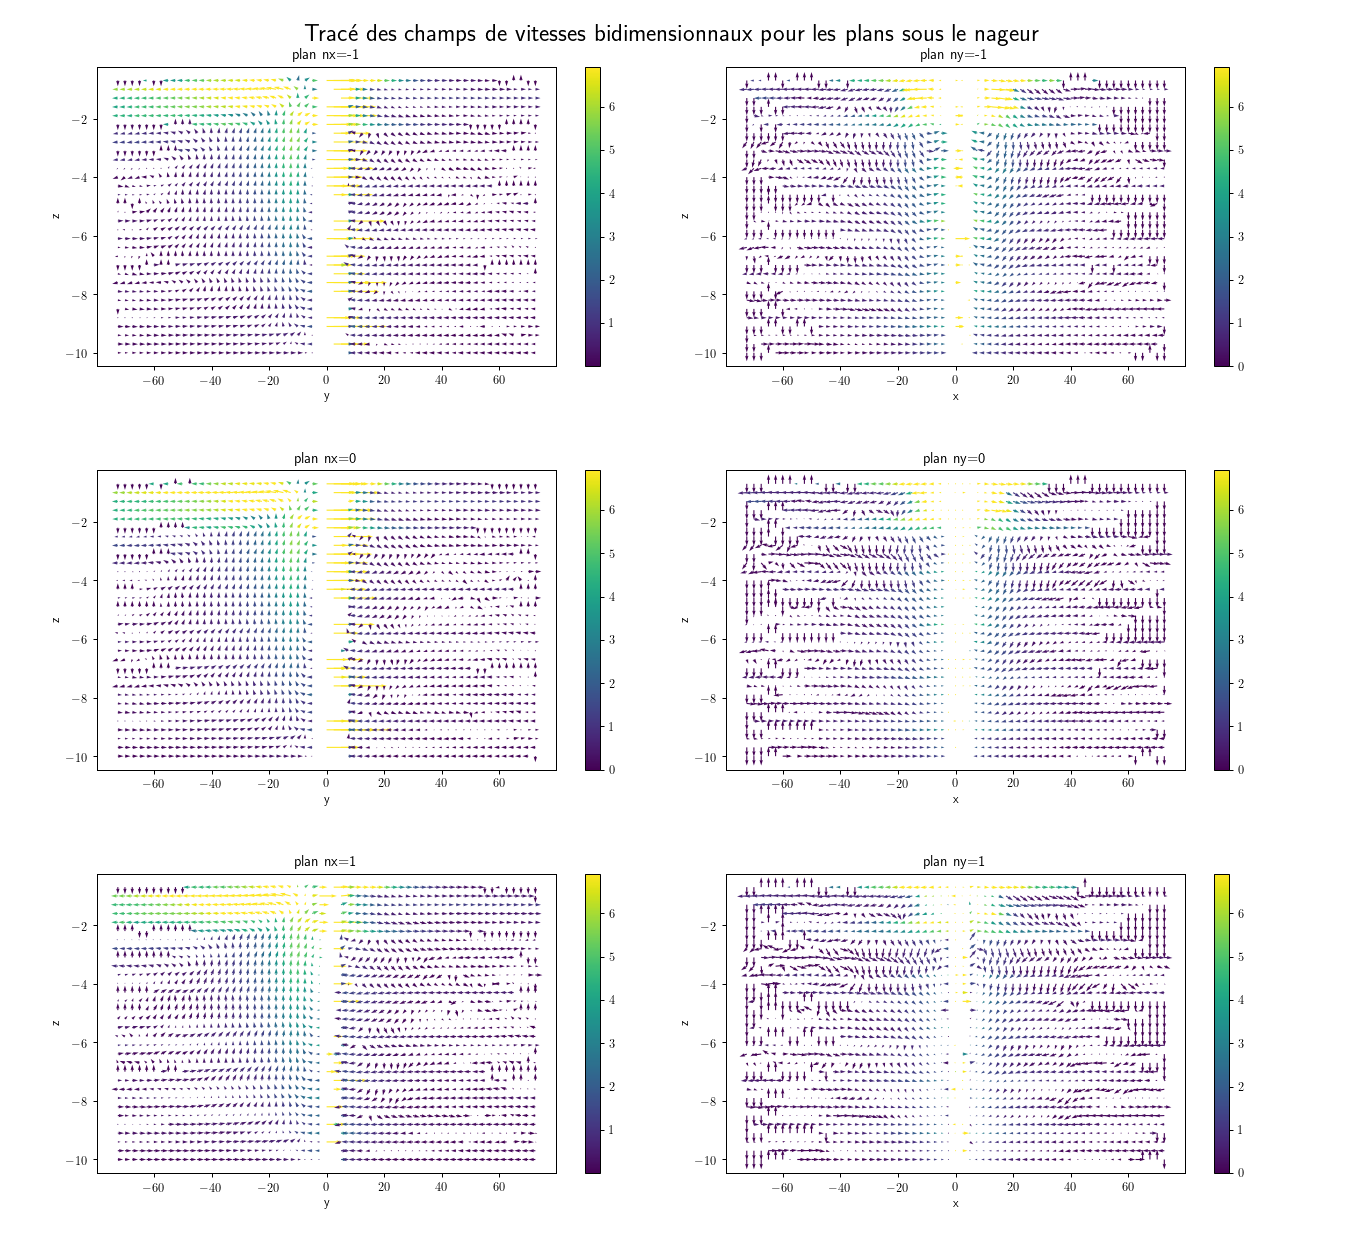

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [71]:
%matplotlib notebook
plan=30 #Choix du plan
plot_champ_vitesse_sous_nageur(u,v,vz,dx,dy,z_2D,plan,'Tracé des champs de vitesses bidimensionnaux pour les plans sous le nageur')

<IPython.core.display.Javascript object>


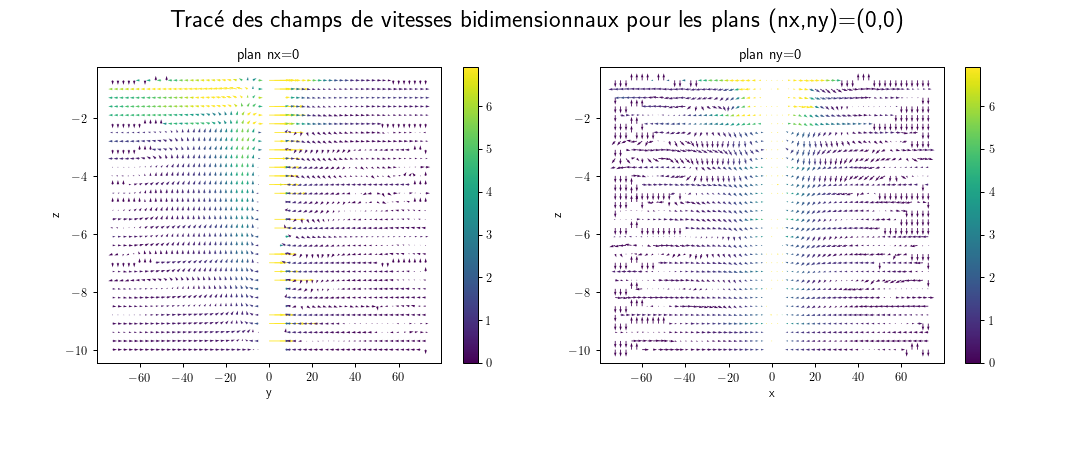

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


In [92]:
%matplotlib notebook
plan=30 #Choix du plan
plot_champ_vitesse_sous_nageur2(u,v,vz,dx,dy,z_2D,plan,'Tracé des champs de vitesses bidimensionnaux pour les plans (nx,ny)=({},{})'.format(plan-30,plan-30))

# Tracé des champs 3D

In [24]:
def plot_champ_vitesse3D(u,v,vz,x,y,z,title):
    "Fonction de tracé du champ de vitesse 3D"
    #norme
    velocity=np.sqrt(u**2+v**2+vz**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = velocity
    #colors[velocity>velmax]=velmax
    # norm = Normalize()
    # norm.autoscale(colors)
    
    #nombre de flèches
    p=10
    x=x[:,::p,::p]
    y=y[:,::p,::p]
    u=u[:,::p,::p]
    v=v[:,::p,::p]
    vz=vz[:,::p,::p]
    z=z[:,::p,::p]
    #velocity=velocity[::2,:]
    
    #plot   
    fig=plt.figure()
    ax = fig.gca(projection='3d')
    im=ax.quiver(z,x,y,vz,u,v,normalize=True,length=0.5)
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    plt.tight_layout(pad=3)
    plt.show()

In [25]:
print(np.shape(u))
print(np.shape(v))
print(np.shape(vz))
print(np.shape(dx))
print(np.shape(dy))
print(np.shape(z))

(32, 59, 59)
(32, 59, 59)
(32, 59, 59)
(32, 59, 59)
(32, 59, 59)
(32, 1)


In [99]:
#tableau des z:
z_3D=np.hstack((z_2D,z_2D))
for i in range(57):
    z_3D=np.hstack((z_3D,z_2D))
z_3D=np.reshape(z_3D,(P,59,59))
print(np.shape(z_3D))
#print(z_3D)

(32, 59, 59)


<IPython.core.display.Javascript object>


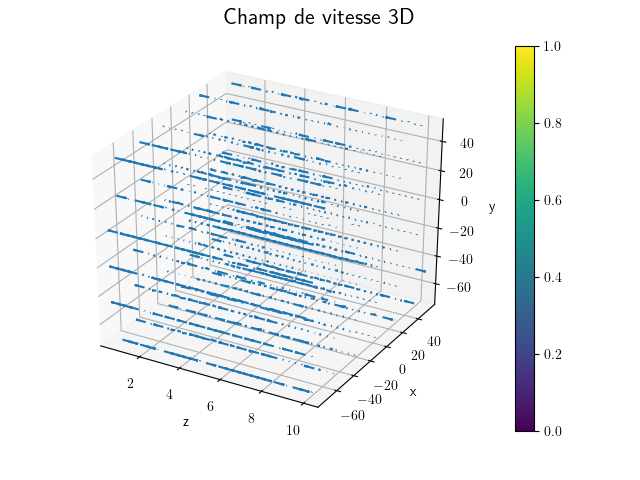

In [27]:
#plot_champ_vitesse3D(u,v,vz,dx,dy,z_3D,'Champ de vitesse 3D')